In [1]:
import torch
import argparse
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import os, sys


os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

# m1: no LA
# m2: FC -> GAP
# m3: no DFT
model_scheme = "m123" # org, m1, m12, m123
n_classes = 6

class Args(object):
    def __init__(self, n_epochs, lr, n_classes, n_samples, distance):
        self.n_epochs = n_epochs
        self.lr = lr
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.distance = distance

# Make custom dataset
class MyDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        
    def __getitem__(self, idx):
        image = torch.FloatTensor(self.images[idx])
        # image = (image + 120.2075) / 20.1417
        label = int(self.labels[idx])
        return image, label
        
    def __len__(self):
        return self.images.shape[0]
    

# Define the network (fc)
class CNN_org(nn.Module):
    def __init__(self, n_classes=12):
        super(CNN_org, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(1, 5, kernel_size=5, padding=0)
        self.pool1 = nn.AvgPool2d(kernel_size=4, stride=4)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5, padding=0)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(200, n_classes)  # original -> no padding, 200 / M1 -> padding, 240
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x = x.view(-1, 200)
        x = self.fc1(x)
        return x

    
    
# Define the network (fc)
class CNN_m1(nn.Module):
    def __init__(self, n_classes=12):
        super(CNN_m1, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(1, 5, kernel_size=5, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=4, stride=4)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5, padding=2)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(240, n_classes)  # original -> no padding, 200 / M1 -> padding, 240
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x = x.view(-1, 240)
        x = self.fc1(x)
        return x

# Define the network (GAP)
class CNN_m123(nn.Module):
    def __init__(self, n_classes=12):
        super(CNN_m123, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(1, 5, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.relu2 = nn.ReLU()
        self.features = nn.Conv2d(10, n_classes, kernel_size=3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x = self.features(x)
        x = self.gap(x)
        x = x.view(-1, self.n_classes)

        return x


args = Args(n_epochs=200, lr=1e-4, n_classes=6, n_samples=100, distance=100)
    
n_samples = args.n_samples
sample_distance = args.distance

# Load activity image data
if(model_scheme == "org"):
    images = np.load('./real-data/real_images_100_100_6_0826_LinearAcc_AI.npy')#.format(n_samples, sample_distance, args.n_classes))
    labels = np.load('./real-data/real_labels_100_100_6_0826_LinearAcc_AI.npy')#.format(n_samples, sample_distance, args.n_classes))
elif(model_scheme == "m1"):
    images = np.load('./real-data/real_images_100_100_6_0826_M1.npy')#.format(n_samples, sample_distance, args.n_classes))
    labels = np.load('./real-data/real_labels_100_100_6_0826_M1.npy')#.format(n_samples, sample_distance, args.n_classes))
elif(model_scheme == "m12"):
    images = np.load('./real-data/real_images_100_100_6_0826_M1+M2+M3.npy')#.format(n_samples, sample_distance, args.n_classes))
    labels = np.load('./real-data/real_labels_100_100_6_0826_M1+M2+M3.npy')#.format(n_samples, sample_distance, args.n_classes))
elif(model_scheme == "m123"):
    images = np.load('./real-data/real_images_100_100_6_0826_M1+M2+M3.npy')#.format(n_samples, sample_distance, args.n_classes))
    labels = np.load('./real-data/real_labels_100_100_6_0826_M1+M2+M3.npy')#.format(n_samples, sample_distance, args.n_classes))

# Data
dataset = MyDataset(images=images, labels=labels)
# mean, std = get_mean_and_std(dataset)
# print('size: {}, mean: {}, std: {}'.format(len(dataset), mean, std))
split_ratio = 1/6
dataset_size = len(dataset)

indices = list(range(dataset_size))
split = int(np.floor(split_ratio * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset=dataset, batch_size=128, sampler=train_sampler)
test_loader = DataLoader(dataset=dataset, batch_size=128, sampler=test_sampler)

# Parameters
use_cuda = torch.cuda.is_available()
n_epochs = args.n_epochs
learning_rate = args.lr
n_classes = args.n_classes


# Model
if(model_scheme == "org"):
    net = CNN_org(n_classes)
elif(model_scheme == "m1"):
    net = CNN_m1(n_classes)
elif(model_scheme == "m12"):
    net = CNN_m123(n_classes)
elif(model_scheme == "m123"):
    net = CNN_m123(n_classes)

if use_cuda:
    net.cuda()

# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
# optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=5e-4)

# LR scheduler
milestones = []
scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=milestones, gamma=0.1)

print("==> Training..")

# Training
for epoch in range(n_epochs):
    print('Epoch: {}'.format(epoch + 1))
    net.train()
    train_loss = 0
    correct_tr = 0
    total_tr = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
        images = images.unsqueeze(1)
        optimizer.zero_grad()
        images, labels = Variable(images), Variable(labels)
        outputs = net(images)
        loss_tr = criterion(outputs, labels)
        loss_tr.backward()
        optimizer.step()

        train_loss += loss_tr.item()
        _, predicted = torch.max(outputs.data, 1)
        total_tr += labels.size(0)
        correct_tr += predicted.eq(labels.data).cpu().sum()

    print('Train Loss: %.3f | Acc: %.3f%%'% (train_loss/128, 100.*correct_tr/total_tr))

    scheduler.step()

    # Test
    with torch.no_grad():
        net.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0

        for batch_idx, (images, labels) in enumerate(test_loader):
            if use_cuda:
                images, labels = images.cuda(), labels.cuda()
            images = images.unsqueeze(1)
            images, labels = Variable(images), Variable(labels)
            outputs = net(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels.data).cpu().sum()

        print('Test Loss: %.3f | Acc: %.3f%%\n' % (test_loss/128, 100.*correct_test/total_test))

torch.save(net.state_dict(), './pretrained-real-data/MyModel.pth')


==> Training..
Epoch: 1
Train Loss: 0.520 | Acc: 24.608%
Test Loss: 0.057 | Acc: 37.896%

Epoch: 2
Train Loss: 0.270 | Acc: 35.745%
Test Loss: 0.053 | Acc: 48.080%

Epoch: 3
Train Loss: 0.254 | Acc: 47.082%
Test Loss: 0.050 | Acc: 58.097%

Epoch: 4
Train Loss: 0.239 | Acc: 62.888%
Test Loss: 0.047 | Acc: 66.778%

Epoch: 5
Train Loss: 0.226 | Acc: 67.656%
Test Loss: 0.044 | Acc: 68.781%

Epoch: 6
Train Loss: 0.215 | Acc: 68.856%
Test Loss: 0.042 | Acc: 71.786%

Epoch: 7
Train Loss: 0.204 | Acc: 69.990%
Test Loss: 0.040 | Acc: 71.452%

Epoch: 8
Train Loss: 0.192 | Acc: 71.057%
Test Loss: 0.037 | Acc: 69.950%

Epoch: 9
Train Loss: 0.183 | Acc: 71.190%
Test Loss: 0.035 | Acc: 72.120%

Epoch: 10
Train Loss: 0.173 | Acc: 72.024%
Test Loss: 0.033 | Acc: 72.454%

Epoch: 11
Train Loss: 0.164 | Acc: 73.158%
Test Loss: 0.032 | Acc: 74.791%

Epoch: 12
Train Loss: 0.155 | Acc: 74.091%
Test Loss: 0.030 | Acc: 75.793%

Epoch: 13
Train Loss: 0.148 | Acc: 74.658%
Test Loss: 0.029 | Acc: 73.957%

Epoch:

In [22]:
np.set_printoptions(precision=3)
print(np.mean(labels.cpu().detach().numpy()))

1.7471264367816093


In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import load_model
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt




if(model_scheme == "org"):
    print("ORG")
    data = np.load('real-data/real_images_100_100_6_0826_LinearAcc_AI.npy')
    label = np.load('real-data/real_labels_100_100_6_0826_LinearAcc_AI.npy')
elif(model_scheme == "m1"):
    data = np.load('real-data/real_images_100_100_6_0826_M1.npy')
    label = np.load('real-data/real_labels_100_100_6_0826_M1.npy')
elif(model_scheme == "m12"):
    data = np.load('real-data/real_images_100_100_6_0826_M1.npy')
    label = np.load('real-data/real_labels_100_100_6_0826_M1.npy')
elif(model_scheme == "m123"):
    data = np.load('real-data/real_images_100_100_6_0826_M1+M2+M3.npy')
    label = np.load('real-data/real_labels_100_100_6_0826_M1+M2+M3.npy')

data = data[..., np.newaxis]
print(data.shape)    

train_data, test_data, train_label, test_label = train_test_split(data, label, test_size = 0.01, shuffle = True)

##############################  Need more Intuition and study ###############################
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_label))
train_dataset = train_dataset.shuffle(buffer_size=1000000).batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_label))
test_dataset = test_dataset.shuffle(buffer_size=1000000).batch(128)

(3598, 16, 100, 1)


In [25]:

if(model_scheme == "org"):
    inputs = tf.keras.Input(shape=(36,100,1))
    x = layers.Conv2D(5, (5,5))(inputs)
    x = layers.AveragePooling2D((4,4))(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(10,(5,5))(x)
    x = layers.AveragePooling2D((2,2))(x)
    x = layers.ReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(n_classes, activation='softmax')(x)
    outputs = x
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="CNN_org")
    
elif(model_scheme == "m1"):
    inputs = tf.keras.Input(shape=(16,100,1))
    x = layers.Conv2D(5, (5,5), padding='same')(inputs)
    x = layers.AveragePooling2D((4,4))(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(10,(5,5), padding='same')(x)
    x = layers.AveragePooling2D((2,2))(x)
    x = layers.ReLU()(x)
    x = layers.Flatten()(x)
    x= layers.Dense(n_classes, activation='softmax')(x)
    outputs = x
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="CNN_m1")
    
elif(model_scheme == "m12"):
    inputs = tf.keras.Input(shape=(16,100,1))
    x = layers.Conv2D(5, (5,5), padding='same')(inputs)
    x = layers.MaxPool2D((4,4))(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(10,(5,5), padding='same')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_classes,(3,3), padding='same')(x)
    outputs = layers.GlobalAveragePooling2D()(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="CNN_m12")
    
elif(model_scheme == "m123"):
    inputs = tf.keras.Input(shape=(16,100,1))
    x = layers.Conv2D(5, (5,5), padding='same')(inputs)
    x = layers.MaxPool2D((4,4))(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(10,(5,5), padding='same')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_classes,(3,3), padding='same')(x)
    outputs = layers.GlobalAveragePooling2D()(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="CNN_m123")
    
model.summary()
print(net)

pytorch_total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable params: {}".format(pytorch_total_trainable_params))

net.eval()
net.cpu()

m = {}
for k, v in net.named_parameters():
    m[k] = v
    

Model: "CNN_m123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 16, 100, 1)]      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 100, 5)        130       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 25, 5)          0         
_________________________________________________________________
re_lu_14 (ReLU)              (None, 4, 25, 5)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 25, 10)         1260      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 12, 10)         0         
_________________________________________________________________
re_lu_15 (ReLU)              (None, 2, 12, 10)         0  

In [5]:
#print(m['fc1.weight'])
print(model.layers[8].weights[0].shape)
#print(m['conv2.weight'])
print(model.layers[4].weights[0].shape)

IndexError: list index out of range

In [16]:
if(model_scheme == "org"):
    model.layers[1].set_weights([m['conv1.weight'].permute(2,3,1,0).detach(), m['conv1.bias'].detach()])
    model.layers[4].set_weights([m['conv2.weight'].permute(2,3,1,0).detach(), m['conv2.bias'].detach()])
    model.layers[8].set_weights([m['fc1.weight'].permute(1,0).detach(), m['fc1.bias'].detach()])
elif(model_scheme == "m1"):
    model.layers[1].set_weights([m['conv1.weight'].permute(2,3,1,0).detach(), m['conv1.bias'].detach()])
    model.layers[4].set_weights([m['conv2.weight'].permute(2,3,1,0).detach(), m['conv2.bias'].detach()])
    model.layers[8].set_weights([m['fc1.weight'].permute(1,0).detach(), m['fc1.bias'].detach()])
elif(model_scheme == "m12"):
    model.layers[1].set_weights([m['conv1.weight'].permute(2,3,1,0).detach(), m['conv1.bias'].detach()])
    model.layers[4].set_weights([m['conv2.weight'].permute(2,3,1,0).detach(), m['conv2.bias'].detach()])
    model.layers[7].set_weights([m['features.weight'].permute(2,3,1,0).detach(), m['features.bias'].detach()])
elif(model_scheme == "m123"):
    model.layers[1].set_weights([m['conv1.weight'].permute(2,3,1,0).detach(), m['conv1.bias'].detach()])
    model.layers[4].set_weights([m['conv2.weight'].permute(2,3,1,0).detach(), m['conv2.bias'].detach()])
    model.layers[7].set_weights([m['features.weight'].permute(2,3,1,0).detach(), m['features.bias'].detach()])


#print(m['fc1.weight'])
#print(model.layers[8].weights[0])
#print(m['conv2.weight'])
#print(model.layers[4].weights[0])

In [17]:
for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.unsqueeze(1)
#    print("Torch Data Shape: ",images.shape)
    tho = net(images)
    
    images = images.permute(0,2,3,1).numpy()
#    print("Torch Permuted Data Shape: ",images.shape)
    tfo = model.predict(images)
    
    print(tfo[0])
    print(tho[0])
    print()
    break


for ds in test_dataset.take(1):
    images = ds[0]
#    print("TF Data Shape: ", images.shape)
    tfo = model.predict(images)
    
    images = torch.Tensor(images.numpy()).permute(0,3,1,2)
    images.requires_grad = False
#    print("TF Permuted Data Shape: ", images.shape)
    tho = net(images)
    
    print(tfo[0])
    print(tho[0])
    print()
    break
    

[-6.103066   4.1064706 -5.2184844 11.045036  -8.990432  -5.0973134]
tensor([ 17.4477,   5.6252,   4.4246,  -3.6767,   6.7924, -20.1789],
       grad_fn=<SelectBackward>)

[-4.1072245  5.6906652 -3.9324636  8.500538  -7.1065555 -3.3163145]
tensor([-4.5464, -1.1724,  9.0229,  9.0291, -3.3770,  1.5926],
       grad_fn=<SelectBackward>)



In [27]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model_m123_quant.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpkzzv1kgq/assets


INFO:tensorflow:Assets written to: /tmp/tmpkzzv1kgq/assets


9.999999747378752e-05
Epoch 1/500
28/28 [==============================] - 1s 19ms/step - loss: 10.8690 - accuracy: 0.1146 - val_loss: 11.9876 - val_accuracy: 0.0000e+00
9.999999747378752e-05
Epoch 2/500
28/28 [==============================] - 0s 14ms/step - loss: 10.7930 - accuracy: 0.1123 - val_loss: 11.9456 - val_accuracy: 0.0000e+00
9.999999747378752e-05
Epoch 3/500
28/28 [==============================] - 0s 12ms/step - loss: 10.9460 - accuracy: 0.1070 - val_loss: 11.9013 - val_accuracy: 0.0000e+00
9.999999747378752e-05
Epoch 4/500
28/28 [==============================] - 0s 13ms/step - loss: 10.5610 - accuracy: 0.1184 - val_loss: 11.6629 - val_accuracy: 0.0000e+00
9.999999747378752e-05
Epoch 5/500
28/28 [==============================] - 0s 13ms/step - loss: 10.0978 - accuracy: 0.1125 - val_loss: 11.6472 - val_accuracy: 0.0000e+00
9.999999747378752e-05
Epoch 6/500
28/28 [==============================] - 0s 13ms/step - loss: 10.3010 - accuracy: 0.1125 - val_loss: 11.6310 - val_a

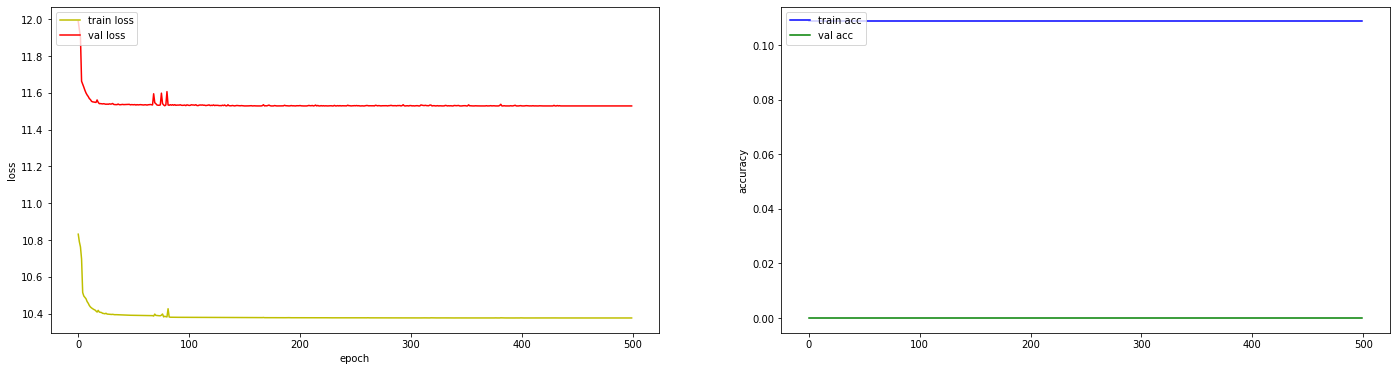

In [26]:
#compile and train
def MultiStepLRSchedule(epoch, lr):
    milestones = []
    gamma = 5e-4
    print(lr)
    for i in range(1,len(milestones)+1):
        if(epoch == milestones[-i]):
            return lr*gamma
    return lr

callbacks = [tf.keras.callbacks.LearningRateScheduler(MultiStepLRSchedule)]
scheduler = tf.keras.optimizers.schedules.LearningRateSchedule
#opt = tf.keras.optimizers.SGD(learning_rate = 1e-4, momentum=0.9)
opt = tf.keras.optimizers.Adam(learning_rate = 1e-4)
model.compile(optimizer = opt , loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_dataset,
                 callbacks=callbacks,
                 validation_data = test_dataset,
                 epochs=500
                )

#plot as graph
plt.figure(figsize=(24,6))
loss_ax = plt.subplot(121)
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax = plt.subplot(122)
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
#evaluate
test_loss , test_acc = model.evaluate(test_dataset, verbose=2)
print(test_acc)
pred = model.predict(test_dataset.take(1))
print()

In [ ]:
#이게 진짜
model.save('HARCNN.pb')
#이게 진짜
export_path = ('/jjw')
model.save(export_path, save_format='tf')
converter = tf.lite.TFLiteConverter.from_saved_model('HARCNN.pb')
tfmodel=converter.convert()
open('har_cnn.tflite','wb').write(tfmodel)

In [69]:
data[:100].reshape(1,-1).shape
np.savez('har_ds_data_.npz', data=data[:100].T, label=)
np.savez('har_ds_data_.npz', data=data[856:856+100].T, label=)
np.savez('har_ds_data_.npz', data=data[1250:1350].T, label=)
np.savez('har_ds_data_.npz', data=data[2550:2650].T, label=)
np.savez('har_ds_data_.npz', data=data[3200:3300].T, label=)
np.savez('har_ds_data_.npz', data=data[3500:3600].T, label=)
np.savez('har_ds_data_.npz', data=net(tf.Tensor(data[0])))
np.savez('har_ds_label.npz', data=data[0], label=np.array([0,0,0,0,0,0]))

[[[[ 2.28298711e+01  2.90968945e+00 -2.87611611e+01 ... -2.40608936e+01
     2.69705830e+01 -7.27422363e+01]
   [ 2.61872051e+01 -5.28220547e+01  1.89129814e+01 ...  8.95289062e-01
     3.89450742e+01 -1.48841807e+01]
   [-3.35733398e-01 -6.33417012e+01 -4.75622314e+01 ... -6.69228574e+01
     1.23326068e+02 -9.90413525e+01]
   ...
   [-1.21093750e+00 -4.42968750e+00 -5.30859375e+00 ...  4.30468750e+00
    -4.80859375e+00  4.26953125e+00]
   [-5.31250000e-01 -1.28671875e+01 -8.38281250e+00 ... -7.61718750e-01
     2.80078125e+00 -6.31640625e+00]
   [ 2.61872051e+01 -5.28220547e+01  1.89129814e+01 ...  8.95289062e-01
     3.89450742e+01 -1.48841807e+01]]

  [[ 1.86891592e+01 -3.29018730e+01  5.20386768e+01 ... -1.15268467e+01
     1.94725371e+01 -6.00962783e+01]
   [ 3.91688965e+01  2.29417822e+01 -2.23822266e-01 ...  4.25262305e+00
     4.51001865e+01  1.74581367e+01]
   [-8.50524609e+00 -7.67710371e+01  1.16499489e+02 ... -6.40131680e+01
     8.93050840e+01 -9.84817969e+01]
   ...
   

TypeError: __init__() missing 2 required positional arguments: 'value_index' and 'dtype'

In [ ]:
print(test_label[0])
print(test_label[10])

np.savez('har_ds_label_3.npz', data=test_data[0],  label=np.array([0,0,0,1,0]))
np.savez('har_ds_label_1.npz', data=test_data[10], label=np.array([0,1,0,0,0]))

a = np.load('har_ds_label_3.npz')
print(a['data'], a['label'])
